In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

## Fitting tuning curves with gradient descent

The firing rates $y$ can be modeled as a Poisson random variable. 

$$
y = \text{Poisson}(\lambda)
$$

The mean $\lambda$ is given by the von Mises tuning model as follows.

$$
\lambda = b + g\exp\Big(\kappa \cos(x - \mu)\Big)
$$

Given a set of observations $(x_i, y_i)$, to identify the parameters $\Theta = \left\{\mu, \kappa, g, b\right\}$ we use gradient descent on the loss function $J$, specified by the negative log-likelihood,

$$
J = -\log\mathcal{L} = \sum_{i} \lambda_i - y_i \log \lambda_i
$$

Taking the gradients, we get:

$$
\frac{\partial J}{\partial \mu} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \kappa \sin(x_i - \mu)\bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial \kappa} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \cos(x_i - \mu)\bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial g} = \sum_{i} g \exp\Big(\kappa \cos(x_i - \mu)\Big) \bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

$$
\frac{\partial J}{\partial b} = \sum_{i} \bigg(1 - \frac{y_i}{\lambda_i}\bigg)
$$

In [260]:
class NeuroPop:
    """
    This class implements several conveniences for 
    plotting, fitting and decoding from population tuning curves
    
    We assume that neurons have a tuning curve of the form:
    f(x) = b_ + g_ * exp(k_ * cos(x - mu_))
    
    Parameters
    ----------
    x: float, n_samples x 1, feature of interest
    Y: float, n_samples x n_neurons, population activity
    
    preferred_feature: n_neurons x 1, preferred feature [-pi, pi]
    Kappa: bool, whether to fit shape parameter or not, default: False
    shape: float, n_neurons x 1, shape (width)
    gain: float,  n_neurons x 1, gain 
    baseline: float,  n_neurons x 1, baseline
    
    learning_rate: float, default: 1e-3
    convergence_threshold: float, default, 1e-5
    maxiter: float, default: 10000
    n_repeats: float, default: 10
    
    verbose: bool, whether to print convergence / loss, default: False
    
    Internal variables
    ------------------
    mu_: float,  n_neurons x 1, preferred feature [-pi, pi]
    Kappa: bool, whether to fit shape parameter or not
    k_: float,  n_neurons x 1, shape (width)
    g_: float,  n_neurons x 1, gain
    b_: float,  n_neurons x 1, baseline
    
    learning_rate: float, default: 1e-3
    convergence_threshold: float, default, 1e-5
    maxiter: float, default: 10000
    n_repeats: float, default: 10
    
    Callable Methods
    ----------------
    encode
    tunefit
    display
    decode

    Class methods
    -------------
    _vonmises
    _loss
    _grad_loss
    _reset_params
    _jointlogL    
    
    """
    
    def __init__(self, x, Y, \
                 preferred_feature = None, Kappa = False, shape = None, gain = None, baseline = None, \
                 learning_rate = 1e-3, convergence_threshold = 1e-5, maxiter = 10000, n_repeats = 10, \
                 verbose = False):
        """
        Initialize the object
        """
        
        self.x = x
        self.Y = Y
        self.n_neurons = Y.shape[1]

        self.Kappa = Kappa
        # If not specified assign random parameters        
        if preferred_feature is None:
            self.mu_ = np.pi*(2.0*np.random.rand(n_neurons) - 1.0)
        else:
            self.mu_ = preferred_feature
            
        if self.Kappa == True and shape is None:
            self.k_ = np.random.rand(n_neurons)  
        elif self.Kappa == False and shape is None:
            self.k_ = np.ones(n_neurons)
        if shape is not None:
            self.k = shape
        
        if gain is None: 
            self.g_ = 5.0*np.random.rand(n_neurons)
        else:
            self.g_ = gain
            
        if baseline is None:
            self.b_ = 10.0*np.random.rand(n_neurons)
        else:
            self.b_ = baseline
        
        # Assign optimization parameters
        self.learning_rate = learning_rate
        self.convergence_threshold = convergence_threshold
        self.maxiter = maxiter
        self.n_repeats = n_repeats
        
        self.verbose = verbose
        
    #-----------------------------------------------------------------------
    def _reset_params(self, n):
        # Assign random parameters        
        self.mu_[n] = np.pi*(2.0*np.random.rand(1) - 1.0)
        if self.Kappa == True:
            self.k_[n] = np.random.rand(1)  
        else:
            self.k_[n] = np.ones(1)
        self.g_[n] = 5.0*np.random.rand(1)
        self.b_[n] = 10.0*np.random.rand(1)
    
    #-----------------------------------------------------------------------
    def _vonmises(self, x, mu, k, g, b):
        """
        The von Mises tuning function
        
        Parameters
        ----------
        x: float, n_samples x 1, feature of interest
        mu: float,  n_neurons x 1, preferred feature [-pi, pi]
        k: float,  n_neurons x 1, shape (width)
        g: float,  n_neurons x 1, gain
        b: float,  n_neurons x 1, baseline
        
        Outputs
        -------
        Y: float, n_samples x 1, firing rates
        """
        y = b + g * np.exp (k * np.cos(x - mu))
        return y
    
    #-----------------------------------------------------------------------
    def _loss(self, x, y, mu, k, g, b):
        """
        The loss function: negative Poisson log likelihood function 
        under the von mises tuning model
        
        Parameters
        ----------
        x: float, n_samples x 1, feature of interest
        y: float, n_samples x 1, firing rates
        mu: float,  n_neurons x 1, preferred feature [-pi, pi]
        k: float,  n_neurons x 1, shape (width)
        g: float,  n_neurons x 1, gain
        b: float,  n_neurons x 1, baseline
        
        Outputs
        -------
        loss: float, scalar
        """
        lmb = b + g * np.exp (k * np.cos(x - mu))
        J = np.sum(lmb) - np.sum(y * lmb)
        return J
    
    #-----------------------------------------------------------------------
    def _grad_loss(self, x, y, mu, k, g, b):
        """
        The gradient of the loss function:
        wrt parameters of the von mises tuning model
        
        Parameters
        ----------
        x: float, n_samples x 1, feature of interest
        y: float, n_samples x 1, firing rates
        mu: float,  n_neurons x 1, preferred feature [-pi, pi]
        k: float,  n_neurons x 1, shape (width)
        g: float,  n_neurons x 1, gain
        b: float,  n_neurons x 1, baseline
        
        Outputs
        -------
        grad_mu: float, scalar
        grad_k: float, scalar
        grad_g: float, scalar
        grad_b: float, scalar
        """
        lmb = b + g * np.exp (k * np.cos(x - mu))
        grad_mu = np.sum(g * np.exp(k * np.cos(x - mu)) * k * np.sin(x - mu) * (1 - y/lmb))
        grad_k = np.sum(g * np.exp(k * np.cos(x - mu)) * np.cos(x - mu) * (1 - y/lmb))
        grad_g = np.sum(g * np.exp(k * np.cos(x - mu)) * (1 - y/lmb))
        grad_b = np.sum((1-y/lmb))
        return grad_mu, grad_k, grad_g, grad_b
    
    #-----------------------------------------------------------------------
    def encode(self, x):
        """
        Compute the firing rates for the population 
        based on the von Mises tuning models
        given features
        
        Parameters
        ----------
        x: float, n_samples x 1, feature of interest
        
        Outputs
        -------
        Y: float, n_samples x n_neurons, population activity
        """
        
        Y = np.zeros([n_samples, n_neurons])
        # For each neuron
        for n in range(0, n_neurons):
            # Compute the firing rate under the von Mises model
            Y[:, n] = self._vonmises(x, self.mu_[n], self.k_[n], self.g_[n], self.b_[n])
        return Y
    
    #-----------------------------------------------------------------------
    def tunefit(self):
        """
        Estimate the parameters of the tuning curve under the 
        von Mises model, given features and population activity
        """
        
        learning_rate = self.learning_rate
        convergence_threshold = self.convergence_threshold
        n_repeats = self.n_repeats
        maxiter = self.maxiter
        
        # Fit model for each neuron
        for n in range(0, self.n_neurons):

            # Collect parameters for each repeat
            fit_params = list()
            
            # Repeat several times over random initializations (global optimization)
            for repeat in range(0, n_repeats):
                self._reset_params(n)
                fit_params.append({'mu': self.mu_[n], 'k': self.k_[n], 'g': self.g_[n], 'b': self.b_[n], 'loss': 0.0})
                
                # Collect loss and delta loss for each iteration
                L, DL = list(), list()

                # Gradient descent iterations (local optimization)
                for t in range(0, maxiter):

                    converged = False

                    # Compute gradients
                    grad_mu_, grad_k_, grad_g_, grad_b_ = \
                    self._grad_loss(self.x, self.Y[:,n], \
                                    fit_params[repeat]['mu'], \
                                    fit_params[repeat]['k'], \
                                    fit_params[repeat]['g'], \
                                    fit_params[repeat]['b'])

                    # Update parameters
                    fit_params[repeat]['mu'] = fit_params[repeat]['mu'] - learning_rate*grad_mu_
                    if self.Kappa == True:
                        fit_params[repeat]['k'] = fit_params[repeat]['k'] - learning_rate*grad_k_  
                    fit_params[repeat]['g'] = fit_params[repeat]['g'] - learning_rate*grad_g_
                    fit_params[repeat]['b'] = fit_params[repeat]['b'] - learning_rate*grad_b_

                    # Update loss            
                    L.append(self._loss(self.x, self.Y[:,n], \
                                        fit_params[repeat]['mu'], \
                                        fit_params[repeat]['k'], \
                                        fit_params[repeat]['g'], \
                                        fit_params[repeat]['b']))

                    # Update delta loss and check for convergence
                    if t > 1:
                        DL.append(L[-1] - L[-2])
                        if np.abs(DL[-1] / L[-1]) < convergence_threshold:
                            converged = True

                    # Sometimes k is negative but this needs to be corrected
                    if fit_params[repeat]['k'] < 0:
                        fit_params[repeat]['k'] = -fit_params[repeat]['k']
                        fit_params[repeat]['mu'] = fit_params[repeat]['mu'] + np.pi

                    # Make sure mu is between [-pi, pi]
                    fit_params[repeat]['mu'] = np.arctan2(np.sin(fit_params[repeat]['mu']), \
                                                          np.cos(fit_params[repeat]['mu']))
                             
                    # Check for convergence
                    if converged == True:
                        break
                
                # Store the converged loss function
                msg = '\tConverged. Loss function: {0:.2f}'.format(L[-1])
                #logger.info(msg)
                #logger.info('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                if self.verbose == True:
                    print(msg)
                fit_params[repeat]['loss'] = L[-1]
            
            # Assign the global optimum
            amin = np.array([d['loss'] for d in fit_params]).argmin()
            self.mu_[n] = fit_params[amin]['mu']
            self.k_[n] = fit_params[amin]['k']
            self.g_[n] = fit_params[amin]['g']
            self.b_[n] = fit_params[amin]['b']
                             
        return self
    
    #-----------------------------------------------------------------------
    def decode(self):
        """
        Given population activity estimate the feature that generated it
        """
        
    #-----------------------------------------------------------------------
    def display(self):
        """
        Visualize tuning curves and parameter estimates
        """
        #for 

### Simulate a population of neurons

In [261]:
# Simulate a population of two neurons
n_samples = 1000
n_neurons = 2

# Random features [-pi, pi]
x = 2.0*np.pi*np.random.rand(n_samples) - np.pi

# Simulate random tuning parameters
mu = np.pi*(2.0*np.random.rand(n_neurons) - 1.0)
#k = 2.0*np.random.rand(n_neurons)
k = np.ones(n_neurons)
g = 5.0*np.random.rand(n_neurons)
b = 10.0*np.random.rand(n_neurons)

# Calculate firing rates under a von mises model
Y = np.zeros([n_samples, n_neurons])
for n in range(0, n_neurons):
    Y[:,n] = np.transpose(b[n] + g[n] * np.exp (k[n] * np.cos(x - mu[n])))

# Add noise    
Y = Y + np.random.poisson(1.0, Y.shape)

### Create a NeuroPop object

In [262]:
pop = NeuroPop(x, Y)

### Compute the population activity for a given feature

In [263]:
Y1 = pop.encode(x)

### Plot the simulated and randomly initialized tuning curves

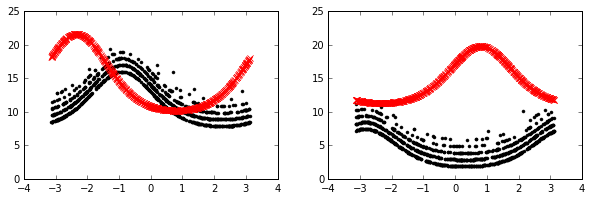

In [264]:
plt.figure(figsize=[10,3])

plt.subplot(121)
plt.hold
plt.plot(x, Y[:,0], 'k.')
plt.plot(x, Y1[:,0], 'rx')
plt.ylim([0, 25])

plt.subplot(122)
plt.hold
plt.plot(x, Y[:,1], 'k.')
plt.plot(x, Y1[:,1], 'rx')
plt.ylim([0, 25])

plt.show()

### Fit the tuning curves with gradient descent

In [266]:
pop = pop.tunefit()

<__main__.NeuroPop instance at 0x7f99a2dafbd8>

### Compute the population activity with the fit tuning curves

In [271]:
Y2 = pop.encode(x)

### Plot the simulated and fit tuning curves

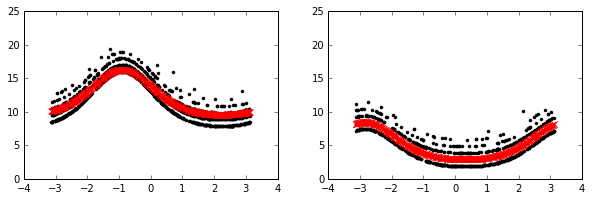

In [273]:
plt.figure(figsize=[10,3])

plt.subplot(121)
plt.hold
plt.plot(x, Y[:,0], 'k.')
plt.plot(x, Y2[:,0], 'rx')
plt.ylim([0, 25])

plt.subplot(122)
plt.hold
plt.plot(x, Y[:,1], 'k.')
plt.plot(x, Y2[:,1], 'rx')
plt.ylim([0, 25])

plt.show()